In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler

In [33]:
task = "classification" #"classification" #"regression"
data = "openml_9946" 
# "openml_43" "openml_3917" "openml_9946" "openml_9978" "openml_146819" "openml_167120"
#"openml_361242" #"openml_361243" #"openml_361247" #"openml_361251" "openml_361253" "openml_361254" "openml_361256" "openml_361259" "openml_361260""openml_361622"
ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
combined_df = pd.DataFrame()
split_seeds = [1,2,3]
rf_seeds = [1,2,3]
for split_seed in split_seeds:
    for rf_seed in rf_seeds:
        df = pd.read_csv(os.path.join(ablation_directory, f"split_seed_{split_seed}rf_seed_{rf_seed}/results.csv"))
        combined_df = pd.concat([combined_df, df], ignore_index=True)


# rf_plus_directory = f'/scratch/users/zhongyuan_liang/saved_models/{task_name}'
# combined_df_rf_plus = pd.DataFrame()
# for file in os.listdir(rf_plus_directory):
#     if file.endswith(".csv"):
#         df = pd.read_csv(os.path.join(rf_plus_directory, file))
#         combined_df_rf_plus = pd.concat([combined_df_rf_plus, df], ignore_index=True)

In [34]:
combined_df.head()

,sample_row_n,sample_row_n_name,rep,n_estimators,min_samples_leaf,max_features,random_state,model,fi,train_size,test_size,num_features,data_split_seed,rf_seed,sorted_feature_0,sorted_feature_1,sorted_feature_2,sorted_feature_3,sorted_feature_4,sorted_feature_5,sorted_feature_6,sorted_feature_7,sorted_feature_8,sorted_feature_9,sorted_feature_10,sorted_feature_11,sorted_feature_12,sorted_feature_13,sorted_feature_14,sorted_feature_15,sorted_feature_16,sorted_feature_17,sorted_feature_18,sorted_feature_19,sorted_feature_20,sorted_feature_21,sorted_feature_22,sorted_feature_23,sorted_feature_24,sorted_feature_25,sorted_feature_26,sorted_feature_27,sorted_feature_28,sorted_feature_29,num_features_selected_0.05,RF_Classifier_LogLoss_top_0.05,RF_Classifier_AUROC_top_0.05,xgboost_classifier_LogLoss_top_0.05,xgboost_classifier_AUROC_top_0.05,Logistic_Regression_LogLoss_top_0.05,Logistic_Regression_AUROC_top_0.05,num_features_selected_0.1,RF_Classifier_LogLoss_top_0.1,RF_Classifier_AUROC_top_0.1,xgboost_classifier_LogLoss_top_0.1,xgboost_classifier_AUROC_top_0.1,Logistic_Regression_LogLoss_top_0.1,Logistic_Regression_AUROC_top_0.1,num_features_selected_0.15,RF_Classifier_LogLoss_top_0.15,RF_Classifier_AUROC_top_0.15,xgboost_classifier_LogLoss_top_0.15,xgboost_classifier_AUROC_top_0.15,Logistic_Regression_LogLoss_top_0.15,Logistic_Regression_AUROC_top_0.15,num_features_selected_0.2,RF_Classifier_LogLoss_top_0.2,RF_Classifier_AUROC_top_0.2,xgboost_classifier_LogLoss_top_0.2,xgboost_classifier_AUROC_top_0.2,Logistic_Regression_LogLoss_top_0.2,Logistic_Regression_AUROC_top_0.2,num_features_selected_0.3,RF_Classifier_LogLoss_top_0.3,RF_Classifier_AUROC_top_0.3,xgboost_classifier_LogLoss_top_0.3,xgboost_classifier_AUROC_top_0.3,Logistic_Regression_LogLoss_top_0.3,Logistic_Regression_AUROC_top_0.3,num_features_selected_0.4,RF_Classifier_LogLoss_top_0.4,RF_Classifier_AUROC_top_0.4,xgboost_classifier_LogLoss_top_0.4,xgboost_classifier_AUROC_top_0.4,Logistic_Regression_LogLoss_top_0.4,Logistic_Regression_AUROC_top_0.4,num_features_selected_0.5,RF_Classifier_LogLoss_top_0.5,RF_Classifier_AUROC_top_0.5,xgboost_classifier_LogLoss_top_0.5,xgboost_classifier_AUROC_top_0.5,Logistic_Regression_LogLoss_top_0.5,Logistic_Regression_AUROC_top_0.5,num_features_selected_0.7,RF_Classifier_LogLoss_top_0.7,RF_Classifier_AUROC_top_0.7,xgboost_classifier_LogLoss_top_0.7,xgboost_classifier_AUROC_top_0.7,Logistic_Regression_LogLoss_top_0.7,Logistic_Regression_AUROC_top_0.7,num_features_selected_0.9,RF_Classifier_LogLoss_top_0.9,RF_Classifier_AUROC_top_0.9,xgboost_classifier_LogLoss_top_0.9,xgboost_classifier_AUROC_top_0.9,Logistic_Regression_LogLoss_top_0.9,Logistic_Regression_AUROC_top_0.9,split_seed
0,NaN,keep_all_rows,0,100,3,sqrt,42,RF,LIME_RF,381,188,30,1,1,22,20,23,27,7,6,2,21,13,26,0,1,24,25,28,10,3,5,4,11,8,12,18,15,16,29,17,19,9,14,2,0.662392,0.933583,0.442093,0.942464,0.253543,0.954972,3,0.311769,0.940713,0.442531,0.940901,0.246498,0.953971,5,0.533660,0.962727,0.307444,0.958036,0.180510,0.976986,6,0.200970,0.972170,0.287400,0.961601,0.177781,0.975610,9,0.160783,0.980050,0.167164,0.983615,0.120172,0.989118,12,0.320999,0.977173,0.159985,0.983240,0.119228,0.989118,15,0.334026,0.973921,0.159140,0.985866,0.086355,0.991495,21,0.327271,0.976235,0.159949,0.984115,0.090341,0.992996,27,0.168252,0.979112,0.152165,0.985616,0.083689,0.995622,1
1,NaN,keep_all_rows,0,100,3,sqrt,42,RF,Local_MDI+_Alo_fit_on_all_ranking_RFPlus,381,188,30,1,1,7,6,2,3,4,5,1,22,8,9,10,20,11,27,29,23,13,28,12,21,15,17,14,18,16,26,24,19,25,0,2,0.279616,0.943715,0.411518,0.928018,0.249285,0.953096,3,0.412401,0.955785,0.400139,0.948030,0.257773,0.967980,5,0.409115,0.960225,0.347515,0.957411,0.240576,0.969606,6,0.229177,0.964853,0.348009,0.956785,0.244024,0.964728,9,0.182151,0.976360,0.172349,0.983990,0.106069,0.989619,12,0.188052,0.974484,0.187165,0.981739,0.111137,0.987992,15,0.184416,0.976360,0.160295,0.984240,0.103326,0.991870,21,0.172601,0.980363,0.162525,0.984365,0.091874,0.994497,27,0.33150

In [35]:
assert combined_df.columns[combined_df.isnull().any()] == ['sample_row_n']

### Summarise the Ablation Data

In [36]:
train_size = combined_df["train_size"].unique()[0]
test_size = combined_df["test_size"].unique()[0]
print(f"The training size is {train_size} and the test size is {test_size}")

The training size is 381 and the test size is 188


In [37]:
combined_df["num_features"].unique()

array([30])

### Plot the Ablation Data Performance

In [38]:
num_features = combined_df['num_features'].drop_duplicates().values[0]
metrics = {"regression": ["MSE", "R2"], "classification": ["AUROC", "LogLoss"]} #MSE
ablation_models = {"regression": ["RF_Regressor", "xgboost_Regressor", "Linear_Regressor"],
                   "classification": ["RF_Classifier", "xgboost_classifier", "Logistic_Regression"]}

In [39]:
methods = [
        # 'Random',
        'LIME_RF', 
       'Local_MDI+_Alo_fit_on_all_ranking_RFPlus',
       'Local_MDI+_MDI_fit_on_all_ranking_RFPlus',
       'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus',
       'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus',
       'Local_MDI+_MDI_fit_on_all_ranking_bootstrap_RFPlus',
       'Local_MDI+_MDI_ridge_fit_on_all_ranking_bootstrap_RFPlus',
       'Local_MDI+_MDI_lasso_fit_on_all_ranking_bootstrap_RFPlus',
       'TreeSHAP_RF'
       ]
color_map = {
    # 'Random': 'gray',  # Assign a default neutral color for Random
    'LIME_RF': '#71BEB7',
    'Local_MDI+_Alo_fit_on_all_ranking_RFPlus': '#FF5733',  # Bright color
    'Local_MDI+_MDI_fit_on_all_ranking_RFPlus': 'black',
    'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus': '#3357FF',
    'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus': '#FF33A1',
    'Local_MDI+_MDI_fit_on_all_ranking_bootstrap_RFPlus': '#9C27B0',  # Example purpleish color
    'Local_MDI+_MDI_ridge_fit_on_all_ranking_bootstrap_RFPlus': 'gray',  # Example yellowish color
    'Local_MDI+_MDI_lasso_fit_on_all_ranking_bootstrap_RFPlus': '#4CAF50',  # Example greenish color
    'TreeSHAP_RF': 'orange'
}

In [40]:
# if num_features > 20:
#     all_ratios = [0.01, 0.05, 0.1, 0.15, 0.25, 0.4, 0.5, 0.7, 0.9]
# else:
all_ratios = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
num_features_selected = []
for r in all_ratios:
    num_features_selected.append(combined_df[f"num_features_selected_{r}"].unique()[0])

#### Summary of results

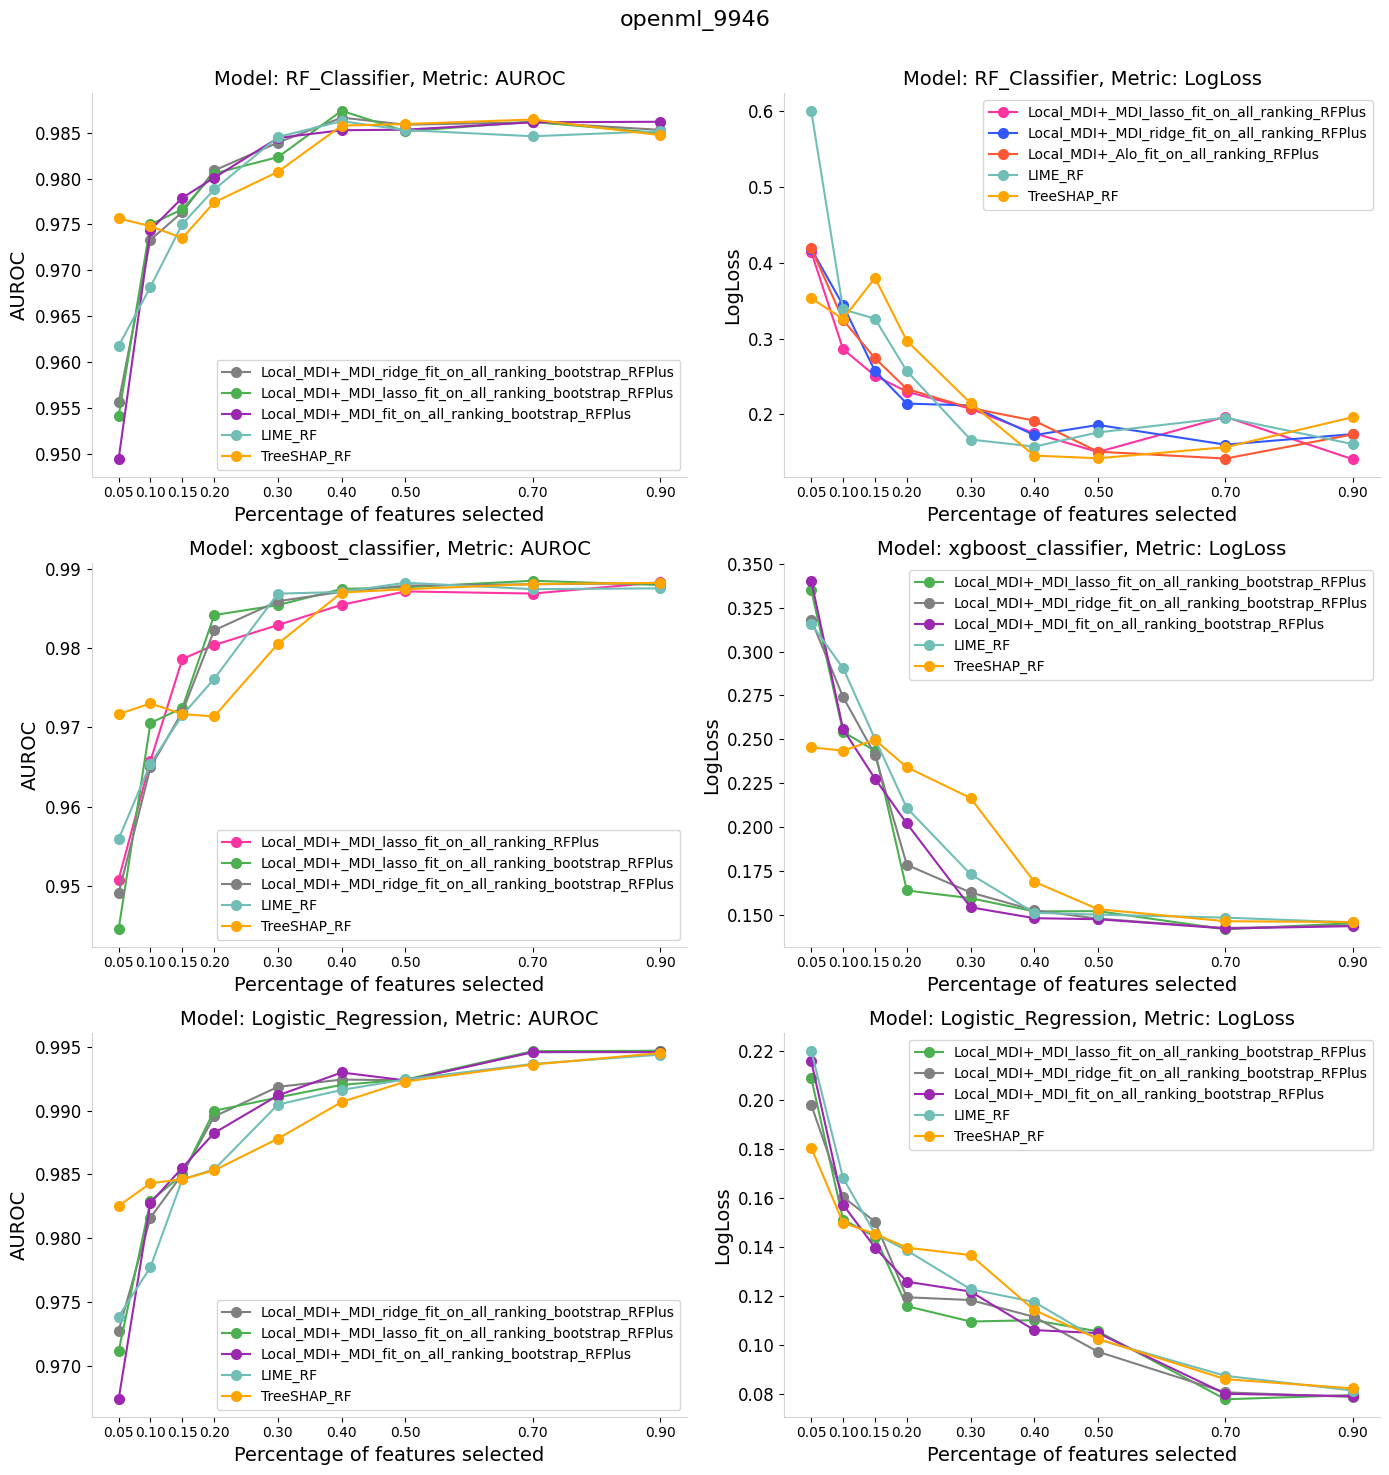

In [41]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'

# Define marker size
marker_size = 7

# Determine the number of rows and columns for subplots
n_models = len(ablation_models[task])
n_metrics = len(metrics[task])

# Create subplots with a grid of n_models rows and n_metrics columns
fig, axs = plt.subplots(
    nrows=n_models,
    ncols=n_metrics,
    figsize=(7 * n_metrics, 5 * n_models)  # Adjust figure size dynamically
)

# Ensure axs is iterable, even if there's only one subplot
if n_models == 1 and n_metrics == 1:
    axs = [[axs]]  # Single subplot case
elif n_models == 1 or n_metrics == 1:
    axs = [axs]  # Single row or column

# Iterate through models and metrics
for i, a_model in enumerate(ablation_models[task]):
    for j, metric in enumerate(metrics[task]):
        ax = axs[i][j] if n_models > 1 and n_metrics > 1 else axs[max(i, j)]
        
        results = {m: [] for m in methods}
        for m in methods:
            for k in all_ratios:
                results[m].append(
                    combined_df[combined_df['fi'] == m][f"{a_model}_{metric}_top_{k}"].mean()
                )
        
        excluded_keys = {'LIME_RF', 'TreeSHAP_RF'}
        filtered_sums = {
            key: sum(values[:5]) 
            for key, values in results.items() if key not in excluded_keys
        }
        if metric == "MSE" or metric == "LogLoss":
            top_3_keys = sorted(filtered_sums, key=filtered_sums.get)[:3]
        else:
            top_3_keys =sorted(filtered_sums, key=filtered_sums.get, reverse=True)[:3]
        top_3_keys.extend(['LIME_RF', 'TreeSHAP_RF'])

        for m in top_3_keys: #methods:
            color = color_map[m]
            ax.plot(
                all_ratios, results[m],
                label=m, linestyle='solid',
                color=color, marker='o', markersize=marker_size
            )

        # Set labels, title, and ticks for each subplot
        ax.set_xticks(all_ratios)
        ax.set_xlabel('Percentage of features selected', fontsize=14)
        ax.set_ylabel(metric, fontsize=14)
        ax.set_title(f"Model: {a_model}, Metric: {metric}", fontsize=14)
        ax.legend(fontsize=10, title_fontsize=12)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
fig.suptitle(data, fontsize=16)  # Add the global title
# plt.savefig(f"results_{data}.png")
plt.show()

In [42]:
X = sample_real_data_X(source="openml", task_id = int(data.split("_")[1]))
y = sample_real_data_y(source="openml", task_id = int(data.split("_")[1]), return_support=False)

/tmp/ipykernel_85468/2977843122.py:1: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  X = sample_real_data_X(source="openml", task_id = int(data.split("_")[1]))
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/openml/tasks/task.py:150: Fu

In [43]:
### Check pairwise correlation between the features
percentage = 0.05
x_corr = {'TreeSHAP_RF': [], 'LIME_RF': [], 'Local_MDI+_MDI_fit_on_all_ranking_RFPlus': [], 'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus': [], 'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus': []}
y_corr = {'TreeSHAP_RF': [], 'LIME_RF': [], 'Local_MDI+_MDI_fit_on_all_ranking_RFPlus': [], 'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus': [], 'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus': []}
for split_seed in [1,2,3]:
    X_train, X_tune, X_test, y_train, y_tune, y_test = apply_splitting_strategy(X, y, "train-test", split_seed)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for fi in ['TreeSHAP_RF', 'LIME_RF', 'Local_MDI+_MDI_fit_on_all_ranking_RFPlus', 'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus', 'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus']:
        for rf_seed in [1,2,3]:
            filtered_df = combined_df[(combined_df['fi'] == fi) & (combined_df['split_seed'] == split_seed) & (combined_df['rf_seed'] == rf_seed)]
            sorted_columns = [col for col in filtered_df.columns if col.startswith('sorted')]
            sorted_feature = []
            for i in range(len(sorted_columns)):
                sorted_feature.append(filtered_df[sorted_columns[i]].values[0])
            num_selected = int(np.ceil(num_features * percentage))
            selected_indices = sorted_feature[:num_selected]
            # compute the pairwise correlation
            X_train_selected = X_train[:, selected_indices]
            df = pd.DataFrame(X_train_selected)
            corr = df.corr()
            corr = np.triu(corr, k=1)
            avg_corr = np.mean(np.abs(corr[corr != 0]))
            target_corr = []
            for i in range(num_selected):
                target_corr.append(np.corrcoef(X_train_selected[:, i], y_train)[0,1])
            avg_target_corr = np.mean(np.abs(target_corr))
            x_corr[fi].append(avg_corr)
            y_corr[fi].append(avg_target_corr)

In [44]:
# compute the mean of x_corr and y_corr
x_corr_mean = {k: np.mean(v) for k, v in x_corr.items()}
y_corr_mean = {k: np.mean(v) for k, v in y_corr.items()}

In [45]:
x_corr_mean

{'TreeSHAP_RF': 0.7951011963254879,
 'LIME_RF': 0.895970917113908,
 'Local_MDI+_MDI_fit_on_all_ranking_RFPlus': 0.8926325640274233,
 'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus': 0.8431096218175954,
 'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus': 0.7651315066884687}

In [46]:
y_corr_mean

{'TreeSHAP_RF': 0.7870499352191732,
 'LIME_RF': 0.7764334086860387,
 'Local_MDI+_MDI_fit_on_all_ranking_RFPlus': 0.7405409617594303,
 'Local_MDI+_MDI_ridge_fit_on_all_ranking_RFPlus': 0.7266613565610414,
 'Local_MDI+_MDI_lasso_fit_on_all_ranking_RFPlus': 0.7068810642803443}

In [47]:
X.shape

(569, 30)

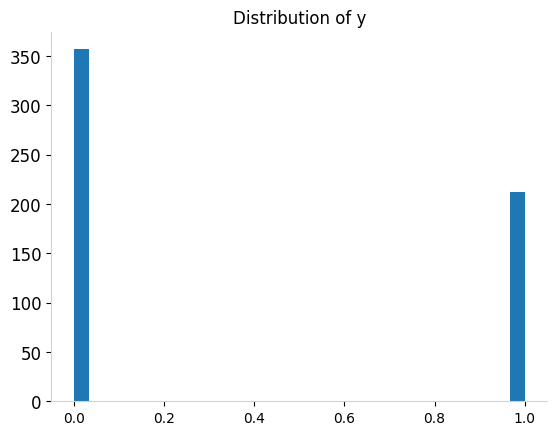

In [48]:
# Plot y
plt.hist(y, bins=30)
plt.title("Distribution of y")
plt.show()